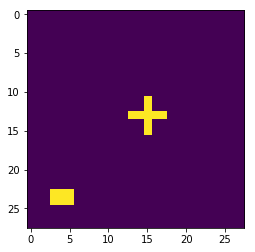

In [112]:
import numpy as np
import matplotlib.pyplot as plt

""" goal: randomly generate a dataset of images with the following properties:
         training set:
             class 0: two cross symbols as the main predictor (add noise and random cropping of 
                                                                 crosses to make less predictive)
                      single solid rectangle in lower left corner as a distractor
             class 1: one cross symbol as main predictor
                      single solid rectangle in lower right corner as distractor
        
         test set:
             as per training but with distractors removed in all cases or most cases...
         
"""

def add_cross(img, class_label, cross_dims=1, add_noise=False):
    """ Add the predictive cross(es) to the image arbirarily (may accidentally intersect the distractor, but
            that's ok). Class label defines how many times the cross is placed to ensure no overlap
    
        Args: 
            class_label: 0 or 1
            add_noise: True/False - if True, add blurring, randomly truncate cross limbs proportional to how
                        long they are
    """

    x_centres = np.random.choice(range(cross_dims, 28-cross_dims), size=[class_label + 1], replace=False)
    y_centres = np.random.choice(range(cross_dims, 28-cross_dims), size=[class_label + 1], replace=False)
    for i in range(class_label+1):

        centre_x = x_centres[i]
        centre_y = y_centres[i]
        img[centre_x-cross_dims:centre_x+cross_dims+1, centre_y] = 1
        img[centre_x, centre_y-cross_dims:centre_y+cross_dims+1] = 1

def add_distractor(img, class_label, tag_dims=[2,3], add_noise=False):
    """ Add a distractor for prediction based on the class label - zero puts it on the left, one puts it on the
            right
        
        Args:
            tag_dims: list of the sizes for the rectangular distractor tag
            add_noise: True/False - if True, blurs the distractor and also shifts its location by some
                        random amount fixed within 2-5 pixels from the edges of the image
    
    """
    tag_buffer = 3
    size_x, size_y = img.shape
    if class_label == 0:
        # buffer of 3 from the border
        img[size_y-tag_buffer-tag_dims[0]:size_y-tag_buffer, tag_buffer:tag_buffer+tag_dims[1]] = 1
        tag_centre_x = (tag_buffer+tag_dims[1]) // 2
        tag_centre_y = 1
    else:
        img[size_y-tag_buffer-tag_dims[0]:size_y-tag_buffer, size_x-tag_buffer-tag_dims[1]:size_x-tag_buffer] = 1
    
    
img_size = 28
label = 0
img_base = np.zeros([img_size,img_size])
add_cross(img_base, label, np.random.randint(1,3))
# capture the original image before the distractor gets added and this forms the segmentation
img_seg = img_base 
add_distractor(img_base, label)
plt.imshow(img_base)
plt.show()

In [111]:
""" Dataset Builder
    Parameters: 

"""

' Dataset Builder\n    Parameters: \n\n'